In [1]:
from stata_preprocessing import *
from llm_simulation import *
from load_environmental_distributions import load_environmental_distribution
# from visualise_responses import *
from fine_tuning_prompts import *
import os
import random
from openai import OpenAI

In [2]:
age_groups = ["18-34", "35-54", "55 or older"]
base_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\Hypothesis-2"
base_stata_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\"

In [3]:
def load_stata_response_file(base_path, question_number):

    if question_number == "zero":

        stata_filepath = os.path.join(base_path, "UKHLS_demo_responses.dta")

    else:

        stata_filepath = os.path.join(base_path, f"UKHLS_question_{question_number}_responses.dta")

    stata_responses = load_stata_file(stata_filepath)

    stata_response_wave_eight, stata_response_wave_nine, stata_response_wave_ten = [stata_responses[stata_responses["wavename"] == wavename] for wavename in [8.0, 9.0, 10.0]]

    return stata_response_wave_eight, stata_response_wave_nine, stata_response_wave_ten


In [4]:
stata_question_one_response_wave_eight, stata_question_one_response_wave_nine, stata_question_one_response_wave_ten = load_stata_response_file(base_stata_filepath, "one")

In [5]:
print(stata_question_one_response_wave_ten.head())

          pidp       hidp fihhmnlabgrs_dv     sex                 marstat  \
109302   22445  277059218     5996.049805  female                 Married   
109303   29925  618630018          1666.0  female                Divorced   
109304   76165  141460418          6732.0  female                 Married   
109305  280165  754371618         12333.0  female                 Married   
109306  333205  414800018     4782.819824  female  Single, nvr marr/civ p   

              qfhigh                                           racel_dv  \
109302  inapplicable  british/english/scottish/welsh/northern irish ...   
109303  inapplicable  british/english/scottish/welsh/northern irish ...   
109304  inapplicable  british/english/scottish/welsh/northern irish ...   
109305  inapplicable  british/english/scottish/welsh/northern irish ...   
109306  inapplicable  british/english/scottish/welsh/northern irish ...   

              lnprnt age_dv         gor_dv    urban_dv       agegr10_dv  \
109302  ina

In [6]:
stata_question_one_response_wave_ten = preprocess_stata_data(stata_question_one_response_wave_ten)

In [7]:
print(stata_question_one_response_wave_ten["scenv_bccc"].value_counts())

Tend to agree                 4680
Neither agree nor disagree    4011
Tend to disagree              1453
Strongly agree                1223
proxy                          525
inapplicable                   524
Strongly disagree              317
missing                          0
refusal                          0
don't know                       0
Name: scenv_bccc, dtype: int64


In [8]:
question_one_strongly_agree = stata_question_one_response_wave_ten[stata_question_one_response_wave_ten["scenv_bccc"] == "Strongly agree"]
question_one_agree = stata_question_one_response_wave_ten[stata_question_one_response_wave_ten["scenv_bccc"] == "Tend to agree"]
question_one_neutral = stata_question_one_response_wave_ten[stata_question_one_response_wave_ten["scenv_bccc"] == "Neither agree nor disagree"]
question_one_disagree = stata_question_one_response_wave_ten[stata_question_one_response_wave_ten["scenv_bccc"] == "Tend to disagree"]
question_one_strongly_disagree = stata_question_one_response_wave_ten[stata_question_one_response_wave_ten["scenv_bccc"] == "Strongly disagree"]

In [9]:
stata_demo_question_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\UKHLS_demo_responses.dta"

stata_demo_question_responses = load_stata_file(stata_demo_question_filepath)

stata_demo_question_responses_wave_eight, stata_demo_question_responses_wave_nine, stata_demo_question_responses_wave_ten = [stata_demo_question_responses[stata_demo_question_responses["wavename"] == wavename] for wavename in [8.0, 9.0, 10.0]]

stata_demo_question_responses_wave_ten_preprocessed = preprocess_stata_data(stata_demo_question_responses_wave_ten)

print(stata_demo_question_responses_wave_ten_preprocessed)

           sex   marstat               qfhigh racel_dv lnprnt age_dv  \
138043    male   Married  Secondary education  British    3.0   55.0   
138044  female   Married  Secondary education  British    2.0   57.0   
138045  female   Married         inapplicable  British    1.0   32.0   
138046    male   Married  Secondary education  British    3.0   33.0   
138049    male  Divorced  Secondary education  British    2.0   61.0   
...        ...       ...                  ...      ...    ...    ...   
159408    male   Married         inapplicable   Indian    2.0   77.0   
159409  female   Married  Secondary education   Indian    6.0   46.0   
159410    male   Married  Secondary education   Indian    2.0   49.0   
159411  female    Single  Secondary education   Indian    2.0   19.0   
159412  female    Single  Secondary education   Indian    2.0   17.0   

            gor_dv    urban_dv         agegr10_dv  \
138043  North East  urban area    50-59 years old   
138044  North East  urban are

In [10]:
print(stata_demo_question_responses_wave_ten_preprocessed["scenv_crlf"].value_counts())

I do quite a few things that are environmentally-friendly      4743
I do one or two things that are environmentally-friendly       4045
I'm environmentally-friendly in most things I do               1928
I don't really do anything that is environmentally-friendly     684
I'm environmentally-friendly in everything I do                 266
missing                                                           0
inapplicable                                                      0
proxy                                                             0
refusal                                                           0
don't know                                                        0
Name: scenv_crlf, dtype: int64


In [11]:
# Define the list of acceptable response options
demo_response_options = [
    "I don't really do anything that is environmentally-friendly",
    "I do one or two things that are environmentally-friendly",
    "I do quite a few things that are environmentally-friendly",
    "I'm environmentally-friendly in most things I do",
    "I'm environmentally-friendly in everything I do"
]

# split the data by responses: "Don't do Anything Environmentally Friendly", "Do One or Two Things Environmentally Friendly", "Do Some Things Environmentally Friendly", "Do Many Things Environmentally Friendly", "Do Everything Environmentally Friendly"
dont_do_anything_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I don't really do anything that is environmentally-friendly"]

do_one_or_two_things_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I do one or two things that are environmentally-friendly"]

do_some_things_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I do quite a few things that are environmentally-friendly"]

do_many_things_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I'm environmentally-friendly in most things I do"]

do_everything_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I'm environmentally-friendly in everything I do"]

In [12]:
def write_balanced_responses_to_json(input_data, variable_name):

    num_rows = input_data.shape[0]

    print(num_rows)
    
    unique_indices = random.sample(range(num_rows), 10)

    # generate 10 random responses for each response type

    for random_index in unique_indices:
        random_row = input_data.iloc[random_index]
        profile_string, opinion_string = visualise_ukhls_profile_and_response(random_row, variable_name)

        if variable_name == "scenv_crlf":

            demo_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_wave_ten_demo.json"

            # write the profile and opinion to a json file
            with open(demo_json_filepath, "r") as file:
                output_data = json.load(file)

            output_data["profiles"].append(profile_string)
            output_data["opinions"].append(opinion_string)
            
            with open(demo_json_filepath, "w") as file:
                json.dump(output_data, file, indent=4)

        if variable_name == "scenv_bccc":

            question_one_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_one_responses_wave_ten.json"

            # write the profile and opinion to a json file
            with open(question_one_json_filepath, "r") as file:
                output_data = json.load(file)

            output_data["profiles"].append(profile_string)
            output_data["opinions"].append(opinion_string)
            
            with open(question_one_json_filepath, "w") as file:
                json.dump(output_data, file, indent=4)

In [13]:
# check the variable "question_one_strongly_disagree"
print(question_one_strongly_disagree["vote3"].value_counts())

Other                     221
Labour                     50
Conservatives              34
Liberal Democrat           12
missing                     0
refusal                     0
don't know                  0
Ulster Unionist             0
sdlp                        0
Democratic Unionist         0
Sinn Fein                   0
British National Party      0
Name: vote3, dtype: int64


In [ ]:
write_balanced_responses_to_json(question_one_strongly_agree, "scenv_bccc")
write_balanced_responses_to_json(question_one_agree, "scenv_bccc")
write_balanced_responses_to_json(question_one_neutral, "scenv_bccc")
write_balanced_responses_to_json(question_one_disagree, "scenv_bccc")
write_balanced_responses_to_json(question_one_strongly_disagree, "scenv_bccc")

In [ ]:
write_balanced_responses_to_json(dont_do_anything_responses, "scenv_crlf")
write_balanced_responses_to_json(do_one_or_two_things_responses, "scenv_crlf")
write_balanced_responses_to_json(do_some_things_responses, "scenv_crlf")
write_balanced_responses_to_json(do_many_things_responses, "scenv_crlf")
write_balanced_responses_to_json(do_everything_responses, "scenv_crlf")

In [ ]:
# convert "Stata-Results/stata_demo_question_responses_wave_ten_demo.json" to "Stata-Results/stata_demo_question_responses_wave_ten_demo.jsonl"
def convert_json_to_jsonl(json_file_path, jsonl_file_path):
    # format the responses in this structure "{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}"
    with open(json_file_path, "r") as file:
        data = json.load(file)

    # {"role": "system", "content": "You are a happy assistant that puts a positive spin on everything."}
    # {"role": "user", "content": "I fell off my bike today."}

    with open(jsonl_file_path, "w") as file:
        for i in range(len(data["profiles"])):
            # Prepare system prompt
            system_prompt = {"role": "system", "content": data["profiles"][i]}
            
            # Prepare assistant response
            assistant_response = {"role": "assistant", "content": data["opinions"][i]}

            # Create a message list and wrap it in a dictionary
            message_dict = {"messages": [system_prompt, assistant_response]}
            
            # Dump the dictionary as a JSON formatted string to the JSONL file
            json.dump(message_dict, file)
            file.write("\n")

In [ ]:
demo_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_wave_ten_demo.json"
demo_jsonl_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_wave_ten_demo.jsonl"
convert_json_to_jsonl(demo_json_filepath, demo_jsonl_filepath)

In [ ]:
question_one_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_one_responses_wave_ten.json"
question_one_jsonl_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_one_responses_wave_ten.jsonl"
convert_json_to_jsonl(question_one_json_filepath, question_one_jsonl_filepath)

In [ ]:
# Load the dataset
with open(demo_jsonl_filepath, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

In [ ]:
hypothesis_one_model_demo_question = OpenAI()

In [ ]:
from api_key import get_api_key

api_key = get_api_key()

In [ ]:
demo_question_model_id = "ft:gpt-3.5-turbo-0125:personal::9lfqGolS"

In [ ]:
def fine_tune_model(path, api_key):
    client = OpenAI(api_key = api_key)

    response = client.files.create(
        file=open(path, 'rb'),
        purpose = 'fine-tune'
    )

    print(response)
    response_id = response.id

In [ ]:
fine_tune_model(question_one_jsonl_filepath, api_key)

In [ ]:
hypothesis_one_question_one_model = OpenAI()

hypothesis_one_question_one_model.fine_tuning.jobs.create(training_file="file-yBmuLEUu1I1MXzYRXGOkcZnn", model="gpt-3.5-turbo")

In [14]:
question_one_model_id = "ft:gpt-3.5-turbo-0125:personal::9lvoEKL1"
question_number = 3
question_one = "Please select the extent to which you agree or disagree with the following statement: My behaviour and everyday lifestyle contribute to climate change."
question_one_response_options = ["Strongly agree", "Tend to agree", "Neither agree nor disagree", "Tend to disagree", "Strongly disagree"]
n_samples = 100
json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\question_one_responses_finetuned.json"
distributions = [load_environmental_distribution("scenv_bccc", 4), load_environmental_distribution("scenv_bccc", 10)]
wave_numbers = [1, 4, 10]
is_simulate = True

scenv_bccc
scenv_bccc


In [15]:
# display the two distributions
for distribution in distributions:
    print(distribution)

{'Strongly agree': 0.0646, 'Tend to agree': 0.305, 'Neither': 0.322, 'Tend to disagree': 0.1, 'Strongly disagree': 0.0294}
{'Strongly agree': 0.0813, 'Tend to agree': 0.3675, 'Neither': 0.3391, 'Tend to disagree': 0.1186, 'Strongly disagree': 0.0251}


In [ ]:
simulate_environmental_responses(question_one, question_number, question_one_response_options, n_samples, json_filepath, distributions, wave_numbers, 1, is_simulate, 0, "", True, question_one_model_id)

{'Strongly agree': 0.0646, 'Tend to agree': 0.305, 'Neither': 0.322, 'Tend to disagree': 0.1, 'Strongly disagree': 0.0294}


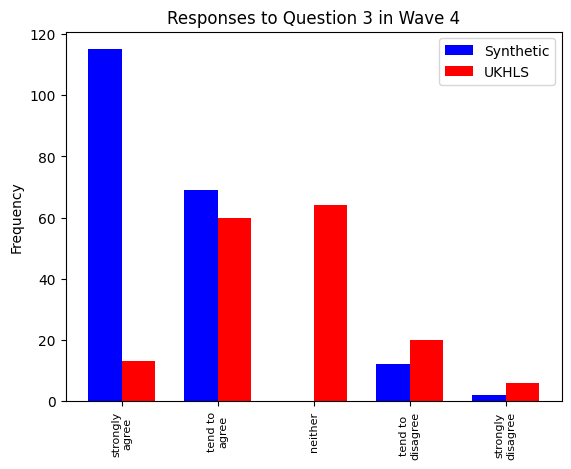

{'Strongly agree': 0.0813, 'Tend to agree': 0.3675, 'Neither': 0.3391, 'Tend to disagree': 0.1186, 'Strongly disagree': 0.0251}


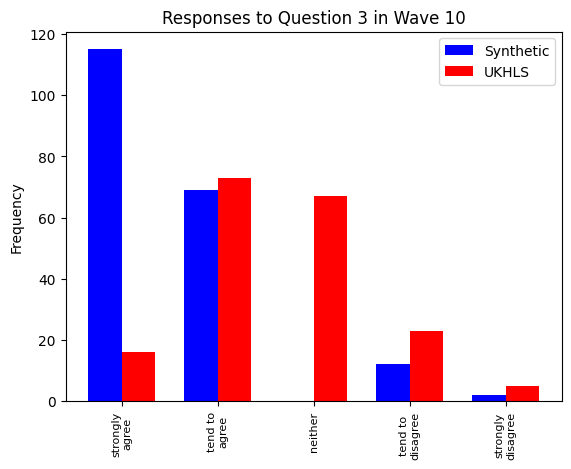

In [20]:
wave_numbers = [4, 10]

wave_number_index = 0
for distribution in distributions:
    print(distribution)
    visualise_synthetic_and_ukhls_distributions(json_filepath, question_one, question_number, distribution, wave_numbers[wave_number_index], True)
    wave_number_index += 1

In [ ]:
# client = OpenAI(api_key = api_key)

# response = client.files.create(
#     file=open(demo_jsonl_filepath, 'rb'),
#     purpose = 'fine-tune'
# )

# print(response)
# response_id = response.id

In [ ]:
# hypothesis_one_model_demo_question.fine_tuning.jobs.create(training_file = response_id, model="gpt-3.5-turbo")

In [ ]:
demo_question = "And which of these would you say best describes your current lifestyle?"
question_number = 1
demo_potential_answers = ["Don't do Anything Environmentally Friendly", "Do One or Two Things Environmentally Friendly", "Do Some Things Environmentally Friendly", "Do Many Things Environmentally Friendly", "Do Everything Environmentally Friendly"]
n_samples = 100
json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\synthetic_demo_responses_finetuned.json"
distributions = [load_environmental_distribution("scenv_crlf", 1), load_environmental_distribution("scenv_crlf", 4), load_environmental_distribution("scenv_crlf", 10)]
wave_numbers = [1, 4, 10]
is_simulate = True

In [ ]:
simulate_environmental_responses(demo_question, question_number, demo_potential_answers, n_samples, json_filepath, distributions, wave_numbers, 1, is_simulate, 0, "", True, demo_question_model_id)